In [25]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from imblearn.over_sampling import SMOTE


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.pipeline_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Case Study: Claims Assessment for Fraud, Waste,and Abuse (FWA) Using Mathematical pipelines

In [70]:
# Load data
file_path = r"..\\data\\Sample_Claims_Data.csv"
df = pd.read_csv(file_path)

# Data overview
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1120 entries, 0 to 1119
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Claim ID               1120 non-null   object 
 1   Member ID              1120 non-null   object 
 2   Claim Amount           1120 non-null   float64
 3   Diagnosis Code         1120 non-null   object 
 4   Procedure Code         1120 non-null   int64  
 5   Provider ID            1120 non-null   object 
 6   Date of Service        1120 non-null   object 
 7   Claim Submission Date  1120 non-null   object 
 8   Previous Claims        1120 non-null   int64  
 9   Member Age             1120 non-null   int64  
 10  Location               1120 non-null   object 
 11  Fraudulent             1120 non-null   int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 105.1+ KB
None


## 1.1 Data Preprocessing

In [71]:
# Data Preprocessing
df['Date of Service'] = pd.to_datetime(df['Date of Service'])
df['Claim Submission Date'] = pd.to_datetime(df['Claim Submission Date'])
df['Location'] = df['Location'].str.upper()

In [72]:
# Check for missing values
print(df.isna().sum())
print((df == 0).any())

Claim ID                 0
Member ID                0
Claim Amount             0
Diagnosis Code           0
Procedure Code           0
Provider ID              0
Date of Service          0
Claim Submission Date    0
Previous Claims          0
Member Age               0
Location                 0
Fraudulent               0
dtype: int64
Claim ID                 False
Member ID                False
Claim Amount             False
Diagnosis Code           False
Procedure Code            True
Provider ID              False
Date of Service          False
Claim Submission Date    False
Previous Claims           True
Member Age               False
Location                 False
Fraudulent                True
dtype: bool


In [73]:
#remove rows in procedure == 0
df = df[df['Procedure Code'] != 0]

In [74]:
# Define urban locations
urban_locations = {'URBAN', 'NAIROBI', 'MOMBASA', 'KIAMBU', 'NAKURU', 'KISUMU', 
                   'KAKAMEGA', 'MACHAKOS', 'UASIN GISHU', 'NYERI', 'MERU', 
                   'KERICHO', 'GARISSA', 'VIHIGA'}

# Function to classify locations
def classify_location(location):
    if location in urban_locations:
        return 'URBAN'
    else:
        return 'RURAL'

# Apply the function to create the new column
# df['Location'] = df['Location'].apply(classify_location)

df['Location'].unique()

array(['URBAN', 'RURAL', "MURANG'A", 'KIAMBU', 'KITUI', 'SAMBURU', 'EMBU',
       'MIGORI', 'KISUMU', 'KAKAMEGA', 'MACHAKOS', 'BUSIA', 'MOMBASA',
       'KAJIADO', 'BUNGOMA', 'BARINGO', 'LAIKIPIA', 'THARAKA-NITHI',
       'HOMABAY', 'UASIN GISHU', 'NYERI', 'MERU', 'KERICHO', 'GARISSA',
       'TAITA TAVETA', 'NAIROBI', 'VIHIGA', 'NAROK', 'ISIOLO', 'NAKURU',
       'SIAYA'], dtype=object)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin

# Define custom transformers
class LocationBinner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(lambda x: 'urban' if x in ['city', 'town'] else 'rural')

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'income']),
        ('cat_onehot', OneHotEncoder(), ['location']),
        ('cat_label', OrdinalEncoder(), ['location']),  # Corrected from LabelEncoder
        ('cat_binary', Pipeline(steps=[
            ('binner', LocationBinner()),
            ('onehot', OneHotEncoder())
        ]), ['location'])
    ])

# Define the model
model = RandomForestClassifier()

# Create a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

# Define parameter grid
param_grid = {
    'preprocessor__cat_onehot__drop': [None, 'first'],
    'preprocessor__cat_label__handle_unknown': ['ignore'],
    'preprocessor__cat_binary__binner__location': [['city', 'town'], ['city']],
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20]
}

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Track results
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [75]:
# Sorting columns for analysis
identifier_columns = ['Claim ID', 'Member ID']
complex_columns = ['Diagnosis Code', 'Procedure Code', 'Provider ID']
date_columns = ['Date of Service', 'Claim Submission Date']
numeric_columns = ['Claim Amount', 'Member Age', 'Previous Claims']
categorical_columns = ['Location']
feature_column = ['Fraudulent']

## SMOTE (Synthetic Minority Over-sampling Technique)

In [92]:
# Base Random Forest pipeline
data = df.copy()

# Apply the function to create the new column
data['Location'] = data['Location'].apply(classify_location)

# Perform one-hot encoding
encoded_data = pd.get_dummies(data['Location'], prefix='location',  dtype=int)

# Concatenate the encoded columns with the original DataFrame
data = pd.concat([data, encoded_data], axis=1)

# Select only the columns to include
y = data.filter(items=feature_column)

columns_to_exclude = identifier_columns + complex_columns + date_columns + categorical_columns + feature_column

# Drop the columns to exclude
X = data.drop(columns=columns_to_exclude)


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Apply SMOTE to the training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

## Preprocessing Pipeline

# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Standardize the features
    ('feature_selection', SelectKBest(score_func=f_classif, k='all')),  # Step 2: Select the top 2 features
    ('classifier', RandomForestClassifier(random_state=42))  # Step 3: Train a Random Forest Classifier
])

# Train the pipeline
pipeline.fit(X_train_resampled, y_train_resampled)

c:\Users\okiki\Desktop\projects\fwa-claims-modelling\.venv\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\okiki\Desktop\projects\fwa-claims-modelling\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k='all')),
                ('classifier', RandomForestClassifier(random_state=42))])

Training Accuracy: 1.00
Random Forest Performance:
Test Accuracy: 0.85
The model may be overfitting.
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       507
           1       0.19      0.22      0.20        51

    accuracy                           0.85       558
   macro avg       0.56      0.56      0.56       558
weighted avg       0.85      0.85      0.85       558



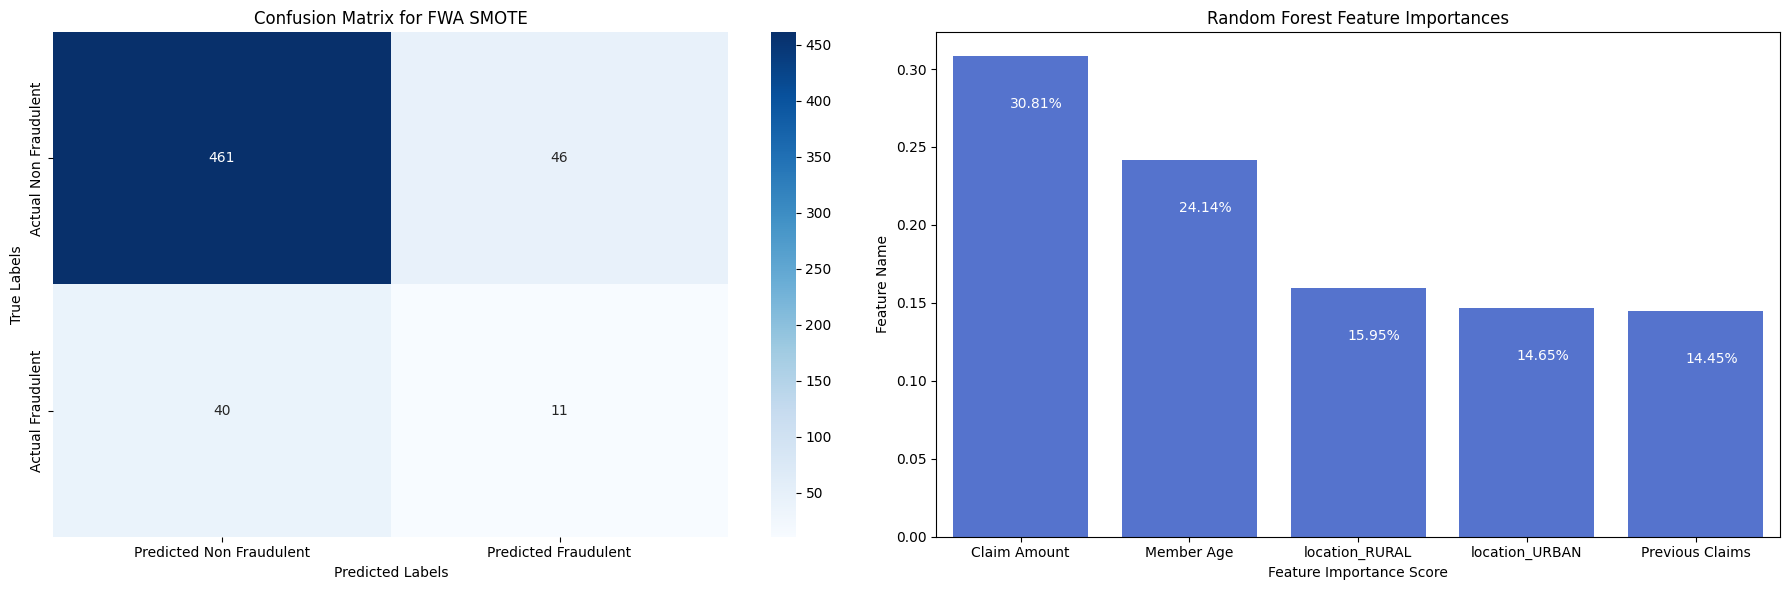

In [93]:
# Evaluate the model on the RESAMPLED training data
y_train_pred = pipeline.predict(X_train_resampled)
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")

# Evaluate the model on the NON-RESAMPLED testing data
y_test_pred = pipeline.predict(X_test)
print("Random Forest Performance:")
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")


# Check for overfitting
if train_accuracy > test_accuracy:
    print("The model may be overfitting.")
else:
    print("The model is not overfitting.")

# more information on the prediction of the dependent variable
print(classification_report(y_test, y_test_pred))


cm_rf = confusion_matrix(y_test, y_test_pred)

model_name = "FWA SMOTE"

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols= 2, figsize=(18, 6))
sns.heatmap(cm_rf, ax=ax1, annot=True, fmt='d', cmap="Blues", 
	xticklabels=["Predicted Non Fraudulent", "Predicted Fraudulent"],
	yticklabels=["Actual Non Fraudulent", "Actual Fraudulent"])

# set labels and title
ax1.set_xlabel("Predicted Labels")
ax1.set_ylabel("True Labels")
ax1.set_title(f"Confusion Matrix for {model_name}")

# Feature importance for Random Forest
# Access the model from the pipeline
model = pipeline.named_steps['classifier']

importances_rf = model.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]

# Feature names sorted by importance
categories = X_train_resampled.columns[indices_rf]

# Importance values (counts) sorted accordingly
counts = importances_rf[indices_rf]

# Create figure and axis
#fig, ax2 = plt.subplots(figsize=(8, 5))

# Plot horizontal barplot (features vs importance)
sns.barplot(y=counts , x=categories , ax=ax2, color="royalblue")

# Set labels and title
ax2.set_xlabel("Feature Importance Score")
ax2.set_ylabel("Feature Name")
ax2.set_title("Random Forest Feature Importances")

# Add labels inside bars in white
for i, (count, category) in enumerate(zip(counts, categories)):
    ax2.text(i+0.25, count - (max(counts) * 0.1), f"{count * 100:.2f}%" , color='white', ha='right', va='center', fontsize=10)


# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Label encoding all locations

c:\Users\okiki\Desktop\projects\fwa-claims-modelling\.venv\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\okiki\Desktop\projects\fwa-claims-modelling\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Training Accuracy: 1.00
Random Forest Performance:
Test Accuracy: 0.85
The model may be overfitting.
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       507
           1       0.22      0.27      0.25        51

    accuracy                           0.85       558
   macro avg       0.57      0.59      0.58       558
weighted avg       0.86      0.85      0.85       558



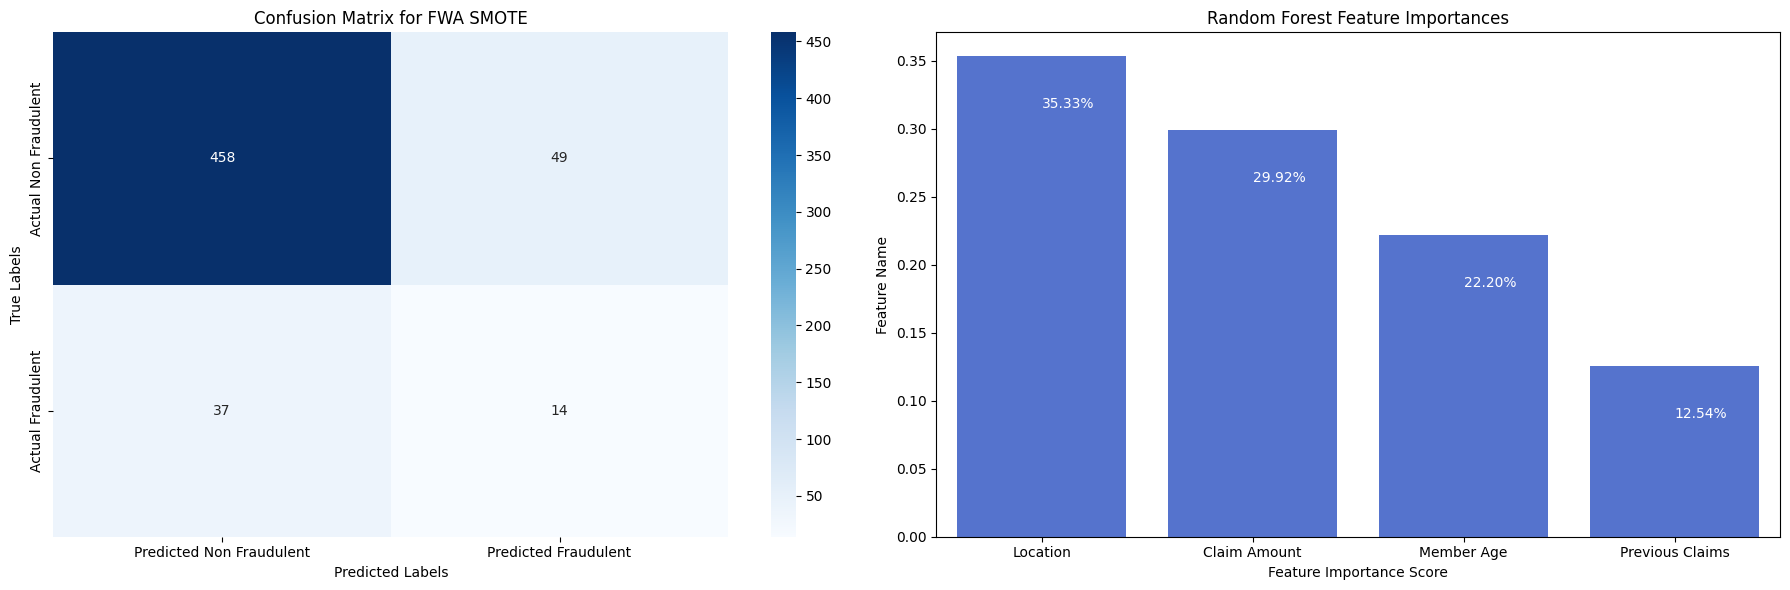

In [94]:

# Base Random Forest pipeline
data = df.copy()


# label encoding
le = LabelEncoder()
data['Location'] = le.fit_transform(data['Location'])

# Select only the columns to include
y = data.filter(items=feature_column)

#columns_to_exclude = identifier_columns + complex_columns + date_columns + categorical_columns + feature_column
columns_to_exclude = identifier_columns + complex_columns + date_columns  + feature_column

# Drop the columns to exclude
X = data.drop(columns=columns_to_exclude)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Apply SMOTE to the training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

## Preprocessing Pipeline

# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Standardize the features
    ('feature_selection', SelectKBest(score_func=f_classif, k='all')),  # Step 2: Select the top 2 features
    ('classifier', RandomForestClassifier(random_state=42))  # Step 3: Train a Random Forest Classifier
])

# Train the pipeline
pipeline.fit(X_train_resampled, y_train_resampled)
# Evaluate the model on the RESAMPLED training data
y_train_pred = pipeline.predict(X_train_resampled)
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")

# Evaluate the model on the NON-RESAMPLED testing data
y_test_pred = pipeline.predict(X_test)
print("Random Forest Performance:")
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")


# Check for overfitting
if train_accuracy > test_accuracy:
    print("The model may be overfitting.")
else:
    print("The model is not overfitting.")

# more information on the prediction of the dependent variable
print(classification_report(y_test, y_test_pred))


cm_rf = confusion_matrix(y_test, y_test_pred)

model_name = "FWA SMOTE"

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols= 2, figsize=(18, 6))
sns.heatmap(cm_rf, ax=ax1, annot=True, fmt='d', cmap="Blues", 
	xticklabels=["Predicted Non Fraudulent", "Predicted Fraudulent"],
	yticklabels=["Actual Non Fraudulent", "Actual Fraudulent"])

# set labels and title
ax1.set_xlabel("Predicted Labels")
ax1.set_ylabel("True Labels")
ax1.set_title(f"Confusion Matrix for {model_name}")

# Feature importance for Random Forest
# Access the model from the pipeline
model = pipeline.named_steps['classifier']

importances_rf = model.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]

# Feature names sorted by importance
categories = X_train_resampled.columns[indices_rf]

# Importance values (counts) sorted accordingly
counts = importances_rf[indices_rf]

# Create figure and axis
#fig, ax2 = plt.subplots(figsize=(8, 5))

# Plot horizontal barplot (features vs importance)
sns.barplot(y=counts , x=categories , ax=ax2, color="royalblue")

# Set labels and title
ax2.set_xlabel("Feature Importance Score")
ax2.set_ylabel("Feature Name")
ax2.set_title("Random Forest Feature Importances")

# Add labels inside bars in white
for i, (count, category) in enumerate(zip(counts, categories)):
    ax2.text(i+0.25, count - (max(counts) * 0.1), f"{count * 100:.2f}%" , color='white', ha='right', va='center', fontsize=10)


# Show the plot
plt.tight_layout()
plt.show()

In [95]:
# One hot encoding all locations

c:\Users\okiki\Desktop\projects\fwa-claims-modelling\.venv\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\okiki\Desktop\projects\fwa-claims-modelling\.venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 8  9 11 12 23 33] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\okiki\Desktop\projects\fwa-claims-modelling\.venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\okiki\Desktop\projects\fwa-claims-modelling\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), f

Training Accuracy: 1.00
Random Forest Performance:
Test Accuracy: 0.82
The model may be overfitting.
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       507
           1       0.18      0.25      0.21        51

    accuracy                           0.82       558
   macro avg       0.55      0.57      0.56       558
weighted avg       0.85      0.82      0.84       558



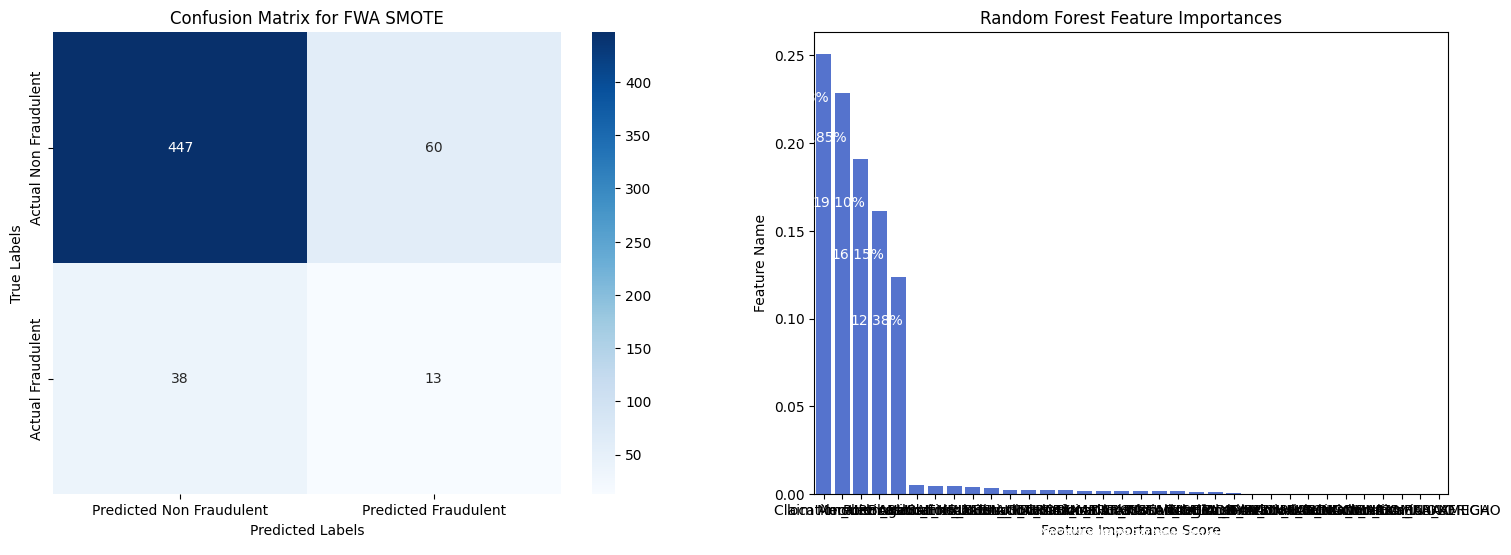

In [96]:

# Base Random Forest pipeline
data = df.copy()

# Perform one-hot encoding
encoded_data = pd.get_dummies(data['Location'], prefix='location',  dtype=int)

# Concatenate the encoded columns with the original DataFrame
data = pd.concat([data, encoded_data], axis=1)

# Select only the columns to include
y = data.filter(items=feature_column)

columns_to_exclude = identifier_columns + complex_columns + date_columns + categorical_columns + feature_column
#columns_to_exclude = identifier_columns + complex_columns + date_columns  + feature_column

# Drop the columns to exclude
X = data.drop(columns=columns_to_exclude)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Apply SMOTE to the training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

## Preprocessing Pipeline

# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Standardize the features
    ('feature_selection', SelectKBest(score_func=f_classif, k='all')),  # Step 2: Select the top 2 features
    ('classifier', RandomForestClassifier(random_state=42))  # Step 3: Train a Random Forest Classifier
])

# Train the pipeline
pipeline.fit(X_train_resampled, y_train_resampled)
# Evaluate the model on the RESAMPLED training data
y_train_pred = pipeline.predict(X_train_resampled)
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")

# Evaluate the model on the NON-RESAMPLED testing data
y_test_pred = pipeline.predict(X_test)
print("Random Forest Performance:")
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")


# Check for overfitting
if train_accuracy > test_accuracy:
    print("The model may be overfitting.")
else:
    print("The model is not overfitting.")

# more information on the prediction of the dependent variable
print(classification_report(y_test, y_test_pred))


cm_rf = confusion_matrix(y_test, y_test_pred)

model_name = "FWA SMOTE"

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols= 2, figsize=(18, 6))
sns.heatmap(cm_rf, ax=ax1, annot=True, fmt='d', cmap="Blues", 
	xticklabels=["Predicted Non Fraudulent", "Predicted Fraudulent"],
	yticklabels=["Actual Non Fraudulent", "Actual Fraudulent"])

# set labels and title
ax1.set_xlabel("Predicted Labels")
ax1.set_ylabel("True Labels")
ax1.set_title(f"Confusion Matrix for {model_name}")

# Feature importance for Random Forest
# Access the model from the pipeline
model = pipeline.named_steps['classifier']

importances_rf = model.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]

# Feature names sorted by importance
categories = X_train_resampled.columns[indices_rf]

# Importance values (counts) sorted accordingly
counts = importances_rf[indices_rf]

# Create figure and axis
#fig, ax2 = plt.subplots(figsize=(8, 5))

# Plot horizontal barplot (features vs importance)
sns.barplot(y=counts , x=categories , ax=ax2, color="royalblue")

# Set labels and title
ax2.set_xlabel("Feature Importance Score")
ax2.set_ylabel("Feature Name")
ax2.set_title("Random Forest Feature Importances")

# Add labels inside bars in white
for i, (count, category) in enumerate(zip(counts, categories)):
    ax2.text(i+0.25, count - (max(counts) * 0.1), f"{count * 100:.2f}%" , color='white', ha='right', va='center', fontsize=10)


# Show the plot
#plt.tight_layout()
plt.show()

c:\Users\okiki\Desktop\projects\fwa-claims-modelling\.venv\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\okiki\Desktop\projects\fwa-claims-modelling\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Training Accuracy: 1.00
Random Forest Performance:
Test Accuracy: 0.85
The model may be overfitting.
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       507
           1       0.19      0.22      0.20        51

    accuracy                           0.85       558
   macro avg       0.56      0.56      0.56       558
weighted avg       0.85      0.85      0.85       558



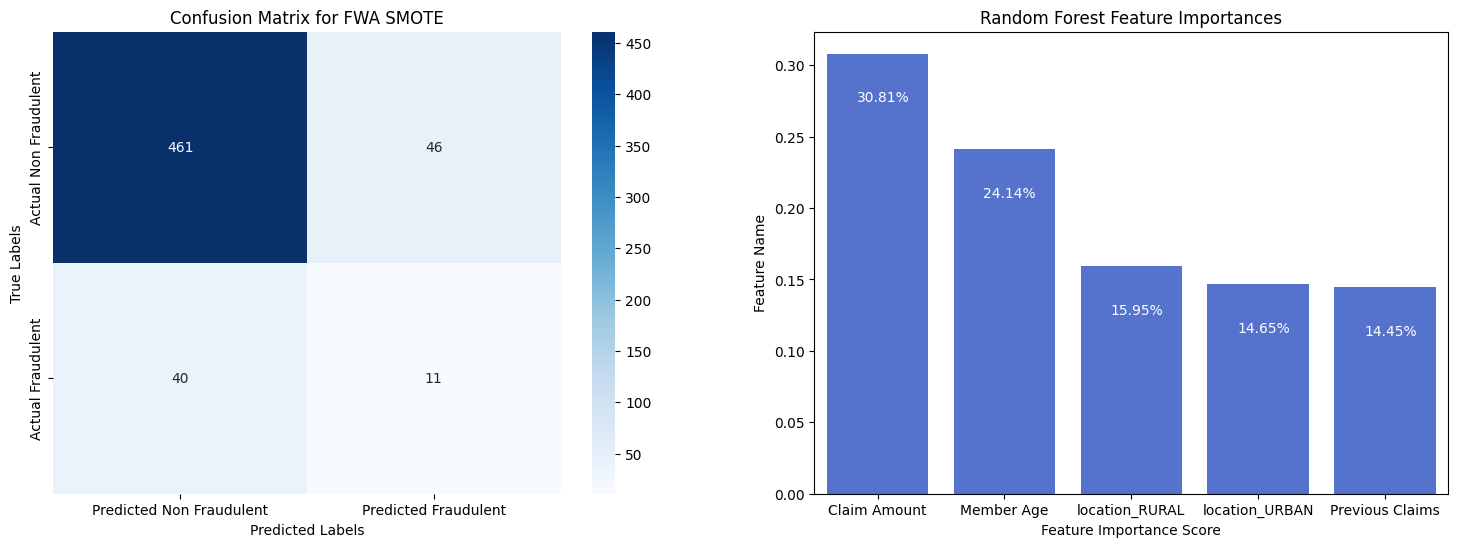

In [85]:

# Base Random Forest pipeline
data = df.copy()

# Apply the function to create the new column
data['Location'] = data['Location'].apply(classify_location)

# Perform one-hot encoding
encoded_data = pd.get_dummies(data['Location'], prefix='location',  dtype=int)

# Concatenate the encoded columns with the original DataFrame
data = pd.concat([data, encoded_data], axis=1)

# Select only the columns to include
y = data.filter(items=feature_column)

columns_to_exclude = identifier_columns + complex_columns + date_columns + categorical_columns + feature_column
#columns_to_exclude = identifier_columns + complex_columns + date_columns  + feature_column

# Drop the columns to exclude
X = data.drop(columns=columns_to_exclude)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Apply SMOTE to the training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

## Preprocessing Pipeline

# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Standardize the features
    ('feature_selection', SelectKBest(score_func=f_classif, k='all')),  # Step 2: Select the top 2 features
    ('classifier', RandomForestClassifier(random_state=42))  # Step 3: Train a Random Forest Classifier
])

# Train the pipeline
pipeline.fit(X_train_resampled, y_train_resampled)
# Evaluate the model on the RESAMPLED training data
y_train_pred = pipeline.predict(X_train_resampled)
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")

# Evaluate the model on the NON-RESAMPLED testing data
y_test_pred = pipeline.predict(X_test)
print("Random Forest Performance:")
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")


# Check for overfitting
if train_accuracy > test_accuracy:
    print("The model may be overfitting.")
else:
    print("The model is not overfitting.")

# more information on the prediction of the dependent variable
print(classification_report(y_test, y_test_pred))


cm_rf = confusion_matrix(y_test, y_test_pred)

model_name = "FWA SMOTE"

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols= 2, figsize=(18, 6))
sns.heatmap(cm_rf, ax=ax1, annot=True, fmt='d', cmap="Blues", 
	xticklabels=["Predicted Non Fraudulent", "Predicted Fraudulent"],
	yticklabels=["Actual Non Fraudulent", "Actual Fraudulent"])

# set labels and title
ax1.set_xlabel("Predicted Labels")
ax1.set_ylabel("True Labels")
ax1.set_title(f"Confusion Matrix for {model_name}")

# Feature importance for Random Forest
# Access the model from the pipeline
model = pipeline.named_steps['classifier']

importances_rf = model.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]

# Feature names sorted by importance
categories = X_train_resampled.columns[indices_rf]

# Importance values (counts) sorted accordingly
counts = importances_rf[indices_rf]

# Create figure and axis
#fig, ax2 = plt.subplots(figsize=(8, 5))

# Plot horizontal barplot (features vs importance)
sns.barplot(y=counts , x=categories , ax=ax2, color="royalblue")

# Set labels and title
ax2.set_xlabel("Feature Importance Score")
ax2.set_ylabel("Feature Name")
ax2.set_title("Random Forest Feature Importances")

# Add labels inside bars
# Add labels inside bars in white
for i, (count, category) in enumerate(zip(counts, categories)):
    ax2.text(i+0.25, count - (max(counts) * 0.1), f"{count * 100:.2f}%" , color='white', ha='right', va='center', fontsize=10)


# Show the plot
#plt.tight_layout()
plt.show()